In [216]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from neural_nets import cnn, fcn
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [217]:
# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [218]:
# Grid search for hyperparameters
# batch_size_list = [1, 2, 4]
# learning_rate_list = [5e-4, 1e-3, 5e-3]
batch_size_list = [1]
learning_rate_list = [5e-4]
hyperparameters = list(itertools.product(batch_size_list, learning_rate_list))

In [219]:
print(hyperparameters)

[(1, 0.0005)]


In [29]:
def train_loop(model, dataloader, loss_fn, optimizer, epochs =1):
    '''
    Train loop will loop over trainset and train provided model. Keep loss history to be sure that 
    it decreases and model learns.    
    '''
    loss_list = []
    N = len(dataloader)
    loss = None
    correct = 0
    total = 0
    step_loss = []
    for ep in range(epochs):
        for it, (X, y) in enumerate(dataloader):
            # print("it: ", it, "\tX: ", X.shape, "\ty: ", y)
            # Run the forward pass
            outputs = model.forward(X)
            # print("Out: ", outputs)
            # return 0
            
            loss = loss_fn(outputs, y)
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Track the accuracy
            step_loss.append(loss.item())
            total += y.size(0)
            _, predicted = torch.max(outputs.data, 1)
            # print("y",y, "\tpred",predicted)
            correct += (predicted == y).sum().item()

            if (ep*N + it+1) % 1000 == 0:
                '''
                Bellow upande loss value to trach training history
                '''
                loss_mean = np.mean(step_loss)
                loss_list.append(loss_mean)
                step_loss = []
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(ep + 1, epochs, it + 1, N, loss_mean, (correct / total) * 100))
                
    return model, loss_list

In [30]:
def test_loop(model, dataloader):
    '''
    Test loop will loop over testset and calculate accuracy for the provided model.
    '''
    model.eval()
    accuracy = []
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in dataloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            accuracy.append(correct / total)
        print('Test Accuracy of the model on the 1000 test images: {} %'.format((correct / total) * 100))

    return accuracy

In [31]:
def main_loop(model, trainset, testset, hyperparameters):
    best_acc = None
    results = {}
    
    for bs, lr in hyperparameters:
        '''
        Loop over all possible hyperparameters and find which model has best accuracy on testset. 
        Loss will be mean squeare error loss and optimizer is stochastic gradient descent. Save loss
        and accuracy history for each hyperparameters for testset.
        '''
        traindata = DataLoader(trainset, batch_size=bs, shuffle=True)
        testdata = DataLoader(testset, batch_size=bs, shuffle=False)

        # print(traindata.size())
        # return 0
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
        label = f'bs_{bs}_lr_{lr}'
        loss = None
        '''
        START YOUR CODE
        '''
        model, loss = train_loop(model, traindata, loss_fn, optimizer, epochs = 1)
        acc = test_loop(model, testdata)
        for a in acc:
            if not best_acc:
                best_acc = a
            elif a > best_acc:
                best_acc = a

        results[label] = loss
    
    return results, best_acc

# CNN training and results

In [33]:
'''
Modify params below to create neural network with important parameters
CNN should have folowing structure [BatchNorm, ConvLayer, MaxPooling, ConvLayer, MaxPooling, Linear] 
'''
params = {
    'Conv1_in_channel': 1,
    'Conv1_out_channel': 32,
    'Conv2_in_channel': 32,
    'Conv2_out_channel': 64,
    'img_size': 7,
    'Conv_kernel_size': 5,
    'Conv_stride': 1,
    'Conv_padding': 2,
    'Pool_kernel_size': 2,
    'Pool_stride': 2,
} # TODO : Updata params and pass to cnn to create neural net
model = cnn(params)

results, cnn_best_acc = main_loop(model, trainset, testset, hyperparameters)
print(results)
print(f'Best accuracy for CNN model is : {cnn_best_acc}')

Epoch [1/1], Step [1000/60000], Loss: 1.6531, Accuracy: 68.40%
Epoch [1/1], Step [2000/60000], Loss: 0.6939, Accuracy: 76.05%
Epoch [1/1], Step [3000/60000], Loss: 0.5898, Accuracy: 79.87%
Epoch [1/1], Step [4000/60000], Loss: 0.6527, Accuracy: 81.53%
Epoch [1/1], Step [5000/60000], Loss: 0.4557, Accuracy: 82.94%
Epoch [1/1], Step [6000/60000], Loss: 0.3003, Accuracy: 84.55%
Epoch [1/1], Step [7000/60000], Loss: 0.2601, Accuracy: 85.77%
Epoch [1/1], Step [8000/60000], Loss: 0.3239, Accuracy: 86.46%
Epoch [1/1], Step [9000/60000], Loss: 0.2051, Accuracy: 87.22%
Epoch [1/1], Step [10000/60000], Loss: 0.2389, Accuracy: 87.85%
Epoch [1/1], Step [11000/60000], Loss: 0.2133, Accuracy: 88.40%
Epoch [1/1], Step [12000/60000], Loss: 0.1876, Accuracy: 88.98%
Epoch [1/1], Step [13000/60000], Loss: 0.1580, Accuracy: 89.44%
Epoch [1/1], Step [14000/60000], Loss: 0.1812, Accuracy: 89.77%
Epoch [1/1], Step [15000/60000], Loss: 0.1775, Accuracy: 90.16%
Epoch [1/1], Step [16000/60000], Loss: 0.1419, Ac

label bs_1_lr_0.0005


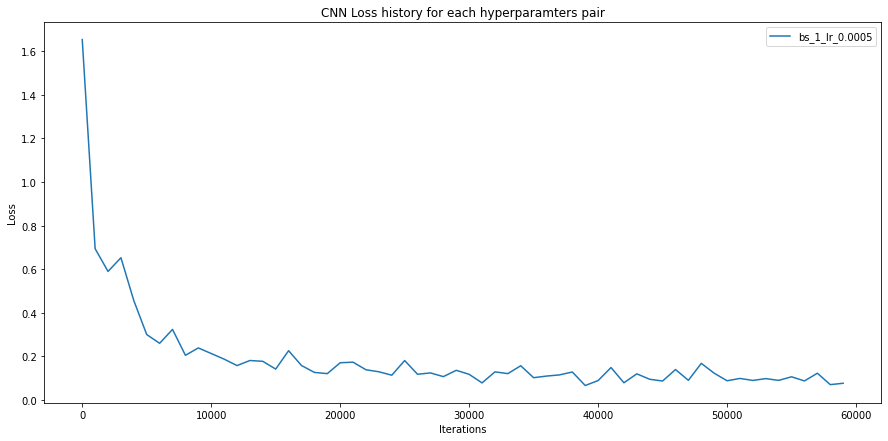

In [34]:
plt.figure(figsize=(15,7))
plt.title(f'CNN Loss history for each hyperparamters pair')
for label in results:
    print("label", label)
    plt.plot(np.arange(len(results[label]))*1000, results[label], label=label)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# FCN training and results

In [35]:
'''
Modify params below to create neural network with important parameters
FCN should have folowing structure [Linear, ReLU, Linear, ReLU]
'''
params = {
    'input_size': 784,
    'hidden_size': 100,
    'output_size': 10,
} # TODO : Updata params and pass to cnn to create neural net
model = fcn(params)
results, fcn_best_acc = main_loop(model, trainset, testset, hyperparameters)
print(f'Best accuracy for FCN model is : {fcn_best_acc}')

Epoch [1/1], Step [1000/60000], Loss: 1.9274, Accuracy: 62.50%
Epoch [1/1], Step [2000/60000], Loss: 1.6717, Accuracy: 73.15%
Epoch [1/1], Step [3000/60000], Loss: 1.6396, Accuracy: 76.93%
Epoch [1/1], Step [4000/60000], Loss: 1.6078, Accuracy: 79.07%
Epoch [1/1], Step [5000/60000], Loss: 1.6117, Accuracy: 80.48%
Epoch [1/1], Step [6000/60000], Loss: 1.5745, Accuracy: 81.85%
Epoch [1/1], Step [7000/60000], Loss: 1.5833, Accuracy: 82.76%
Epoch [1/1], Step [8000/60000], Loss: 1.5690, Accuracy: 83.66%
Epoch [1/1], Step [9000/60000], Loss: 1.5563, Accuracy: 84.61%
Epoch [1/1], Step [10000/60000], Loss: 1.5495, Accuracy: 85.39%
Epoch [1/1], Step [11000/60000], Loss: 1.5593, Accuracy: 85.87%
Epoch [1/1], Step [12000/60000], Loss: 1.5450, Accuracy: 86.42%
Epoch [1/1], Step [13000/60000], Loss: 1.5425, Accuracy: 86.85%
Epoch [1/1], Step [14000/60000], Loss: 1.5348, Accuracy: 87.24%
Epoch [1/1], Step [15000/60000], Loss: 1.5514, Accuracy: 87.45%
Epoch [1/1], Step [16000/60000], Loss: 1.5456, Ac

label bs_1_lr_0.0005


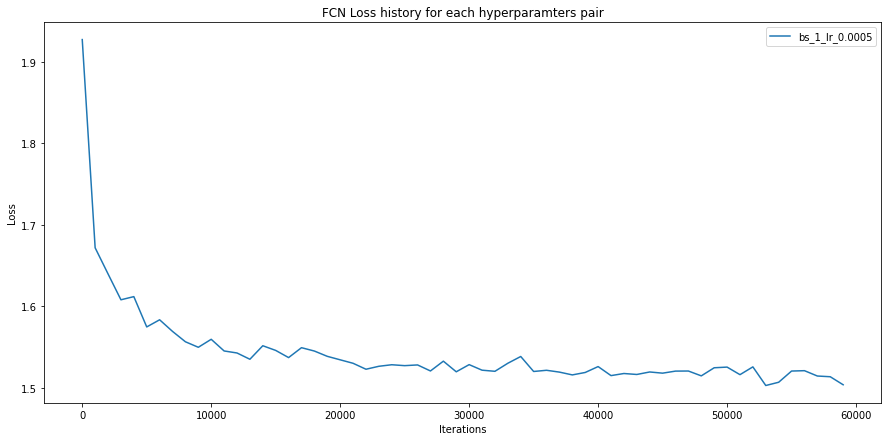

In [36]:
plt.figure(figsize=(15,7))
plt.title('FCN Loss history for each hyperparamters pair')
for label in results:
    print("label", label)
    plt.plot(np.arange(len(results[label]))*1000, results[label], label=label)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()